In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

%matplotlib inline

# Generalização

Neste caderno vamos abordar a questão da generalização: o classificador desenvolvido na aula anterior consegue acertar exemplos que não foram usados para estimar o limiar de classificação?

## Base de Dados e Algoritmo de Classificação

Vamos explorar este problema com a mesma base de dados da aula passada. Também usaremos o mesmo classificador baseado em limiar pela característica **altura**.

In [2]:
df = pd.read_csv('biometria.csv')
df.replace('V', 'Vôlei',inplace=True)
df.replace('F', 'Futebol',inplace=True)

def classificador_limiar(limiar, dados, rotulos=('Futebol', 'Vôlei')):
    resposta = []   
    for idx, dado in dados.iterrows():
        if dado[0] <= limiar:
            resposta.append(rotulos[0])
        else:
            resposta.append(rotulos[1])
    return pd.DataFrame(resposta, columns=['Esporte'])

df.head()

,Esporte,Altura (m),Peso (kg)
0,Vôlei,1.90,76
1,Vôlei,1.98,70
2,Vôlei,2.04,101
3,Vôlei,1.88,77
4,Vôlei,2.14,109


# Conjuntos de treino e teste

A técnica mais comum para avaliar a capacidade de generalização de um classificador consiste em particionar (*split*) a base de dados em dois conjuntos disjuntos: um conjunto para **treino** e outro para **teste**. O conjunto de treino (ou treinamento) é utilizar para estimar os parâmetros do classificador (como por exemplo o limiar do classificador desenvolvido na aula passada). O conjunto de teste é então usado para verificar a capacidade de generalização do classificador, uma vez que ambos conjuntos possuem dados distintos.

In [3]:
from sklearn.model_selection import train_test_split

#A função train_test_split faz ao particionamento (split) da base de dados nos conjuntos de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(df[['Altura (m)', 'Peso (kg)']], df['Esporte'], 
                                                        test_size=0.2, stratify=df['Esporte'].tolist(),
                                                        shuffle=True, random_state=10)

Acima apresento uma nomenclatura comum para nomear conjuntos de treino e teste. Variáveis com o prefixo ``x_`` são características (ou atributos) de entrada, enquanto as variáveis com o prefixo ``y_`` armazenam os rótulos. Os sufixos ``treino`` e ``teste`` claramente indicam quais variáveis armazenam os dados de treino e de teste.

O parametro ``test_size`` indica a fração dos dados da base de dados que serão colocados no conjunto de teste. Seu complemento (``1-test_size``) indica a fração dos dados que serão colocados no conjunto de treino.

O parâmetro ``stratify`` indica os rótulos que são usados para separar os conjuntos de treino e teste de forma estratificada. Isto garante que a proporção dos dados por classe é mantida a mais próxima possível em relação a base de dados original.

Um outro parâmetro importante é o ``random_state``, que é usado como semente do gerador de números aleatórios. Isto permite que os particionamentos possam ser repetidos. Isto ajuda na reprodutibilidade dos experimentos. Falaremos mais sobre isso mais adiante.


In [4]:
print(x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape)
print(y_treino.value_counts())
print(y_teste.value_counts())


(36, 2) (9, 2) (36,) (9,)
Futebol    18
Vôlei      18
Name: Esporte, dtype: int64
Futebol    5
Vôlei      4
Name: Esporte, dtype: int64


Vários particionamentos da base de dados em conjuntos de treino e de teste são possíveis. Veja os gráficos a seguir, mostrando alguns possíveis particionamentos.

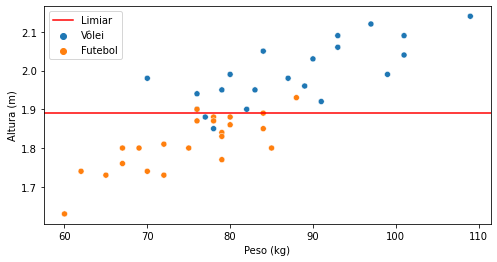

In [5]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='Peso (kg)', y='Altura (m)', hue='Esporte')
plt.axhline(1.891, color='red', label='Limiar')
plt.legend()
plt.show()

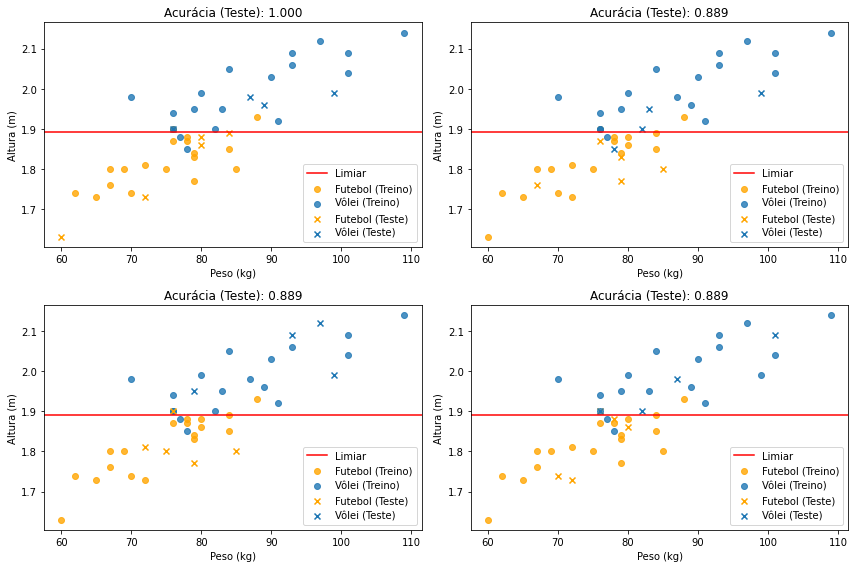

In [6]:
#Este código plota 4 particionamentos da base de dados em conjuntos treino/teste

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
limiar=1.891              #limiar encontrado na aula passada
rns = [999, 42, 87, 51]   #sementes de números aleatórios para usar no train_test_split

for row in range(2):
    for col in range(2):
        
        x_treino, x_teste, y_treino, y_teste = train_test_split(df[['Altura (m)', 'Peso (kg)']], df['Esporte'], 
                                                        test_size=0.2, stratify=df['Esporte'].tolist(),
                                                        shuffle=True, random_state=rns[row * 2 + col])
        
        axes[row][col].scatter(x = x_treino.loc[y_treino[y_treino=='Futebol'].index].values[:,1], 
                           y = x_treino.loc[y_treino[y_treino=='Futebol'].index].values[:,0],
                           label='Futebol (Treino)', c='orange', alpha=0.8)

        axes[row][col].scatter(x = x_treino.loc[y_treino[y_treino=='Vôlei'].index].values[:,1], 
                           y = x_treino.loc[y_treino[y_treino=='Vôlei'].index].values[:,0],
                           label='Vôlei (Treino)', c='#1f77b4', alpha=0.8)

        axes[row][col].scatter(x = x_teste.loc[y_teste[y_teste=='Futebol'].index].values[:,1], 
                           y = x_teste.loc[y_teste[y_teste=='Futebol'].index].values[:,0],
                           label='Futebol (Teste)', marker='x', c='orange')

        axes[row][col].scatter(x = x_teste.loc[y_teste[y_teste=='Vôlei'].index].values[:,1], 
                           y = x_teste.loc[y_teste[y_teste=='Vôlei'].index].values[:,0],
                           label='Vôlei (Teste)', marker='x', c='#1f77b4')

        axes[row][col].axhline(limiar, color='red', label='Limiar')
        
        axes[row][col].legend()
        axes[row][col].set_ylabel('Altura (m)')
        axes[row][col].set_xlabel('Peso (kg)')
        
        predicoes = classificador_limiar(limiar, x_teste)
        acc = accuracy_score(y_teste, predicoes)
        
        axes[row][col].set_title('Acurácia (Teste): %.3f' % (acc))
        
fig.tight_layout()


Note que usamos o melhor limiar encontrado na aula passada. Entretanto, este limiar não é realista, uma vez que o conjunto de treinamento agora é apenas um subconjunto do conjunto de treinamento usado na aula passada. O ideal é estimar o limiar usando apenas o conjunto de treinamento!

A seguir segue um procedimento de aprendizado por busca exaustiva que escolhe o limiar dependendo do conjunto de treinamento.

In [7]:
def busca_exaustiva_classificador_limiar(n_limiares, atributos, rotulos, alt_min, alt_max):

    limiares = np.linspace(alt_min, alt_max, n_limiares)

    melhor_limiar = accuracy_score(rotulos, classificador_limiar(limiares[0], atributos))
    melhor_acuracia = 0

    for limiar in limiares[1:]:
        predicoes = classificador_limiar(limiar, atributos)

        acuracia = accuracy_score(rotulos, predicoes['Esporte'])

        if acuracia > melhor_acuracia:
            melhor_acuracia = acuracia
            melhor_limiar = limiar
            
    return melhor_limiar, melhor_acuracia

Abaixo temos o limiar calculado por busca exaustiva usando apenas os conjuntos de treinamento.

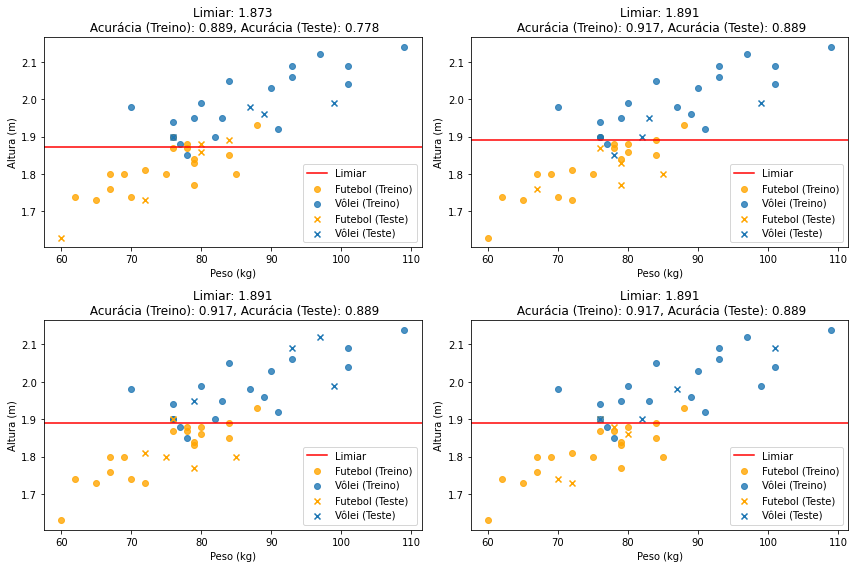

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
limiar=1.891              #limiar encontrado na aula passada
rns = [999, 42, 87, 51]   #sementes de números aleatórios para usar no train_test_split

accs = []

for row in range(2):
    for col in range(2):
        
        x_treino, x_teste, y_treino, y_teste = train_test_split(df[['Altura (m)', 'Peso (kg)']], df['Esporte'], 
                                                        test_size=0.2, stratify=df['Esporte'].tolist(),
                                                        shuffle=True, random_state=rns[row * 2 + col])
        
        melhor_limiar, melhor_acuracia = busca_exaustiva_classificador_limiar(100, x_treino, y_treino, 1.6, 2.2)
        
        axes[row][col].scatter(x = x_treino.loc[y_treino[y_treino=='Futebol'].index].values[:,1], 
                           y = x_treino.loc[y_treino[y_treino=='Futebol'].index].values[:,0],
                           label='Futebol (Treino)', c='orange', alpha=0.8)

        axes[row][col].scatter(x = x_treino.loc[y_treino[y_treino=='Vôlei'].index].values[:,1], 
                           y = x_treino.loc[y_treino[y_treino=='Vôlei'].index].values[:,0],
                           label='Vôlei (Treino)', c='#1f77b4', alpha=0.8)

        axes[row][col].scatter(x = x_teste.loc[y_teste[y_teste=='Futebol'].index].values[:,1], 
                           y = x_teste.loc[y_teste[y_teste=='Futebol'].index].values[:,0],
                           label='Futebol (Teste)', marker='x', c='orange')

        axes[row][col].scatter(x = x_teste.loc[y_teste[y_teste=='Vôlei'].index].values[:,1], 
                           y = x_teste.loc[y_teste[y_teste=='Vôlei'].index].values[:,0],
                           label='Vôlei (Teste)', marker='x', c='#1f77b4')

        axes[row][col].axhline(melhor_limiar, color='red', label='Limiar')
        
        axes[row][col].legend()
        axes[row][col].set_ylabel('Altura (m)')
        axes[row][col].set_xlabel('Peso (kg)')
        
        predicoes = classificador_limiar(melhor_limiar, x_teste)
        acc = accuracy_score(y_teste, predicoes)
        accs.append(acc)
        
        predicoes_treino = classificador_limiar(melhor_limiar, x_treino)
        acc_treino = accuracy_score(y_treino, predicoes_treino)
        
        axes[row][col].set_title('Limiar: %.3f\n Acurácia (Treino): %.3f, Acurácia (Teste): %.3f' % (melhor_limiar, acc_treino, acc))
        
fig.tight_layout()

In [9]:
print("Acurácias: %.3f (min), %.3f (min), %.3f+-%.3f (media+=desvio)" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

Acurácias: 0.778 (min), 0.889 (min), 0.861+-0.048 (media+=desvio)


Note que os melhores limiares nem sempre são os mesmos. Isto quer dizer que dependendo do conjunto de treinamento, o modelo (classificador) gerado pode levar a parametros diferentes, o que pode impactar diretamente em sua assertividade.

Embora a acurácia nos conjuntos de teste (mínimo 0.778, máximo 0.889) tenham sido menor que o obtido na aula passada (0.911), temos uma noção mais realista da capacidade de generalização do classificador. Sabemos que podemos esperar um desempenho entre 0.778 e 0.889 com dados que não foram usados para treinar o classificador. Ou seja, em média o desempenho deste classificador com estes dados é de $0.861 \pm 0.048$. Entretant, esta é uma estimativa de acurácia média é um pouco equivocada, uma vez que podem existir elementos de teste em comum entre os 4 diferentes particionamentos avaliados. Mais adiante iremos estudar uma técnica mais aprimorada para isso chamada de *validação cruzada*.

# Como proceder com bases de dados com mais atributos?